In [ ]:
# default_exp funcs.train_funcs

In [ ]:
%load_ext autoreload
%autoreload 2

# Training loop simulator learning

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.predict import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb

from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def eval_logger(pred_df, target_df, iteration, data_str='Sim. '):
    
    perf_dict,matches,shift = matching(target_df, pred_df, print_res=False,  match_genes=True)
    if 'Inp' in data_str:
        pred_corr = shift_df(pred_df, shift)
        perf_dict, _, _ = matching(target_df, pred_corr, print_res=False,  match_genes=True)

    wandb.log({data_str +'Metrics/eff_3d': perf_dict['eff_3d']}, step=iteration)
    wandb.log({data_str +'Metrics/jaccard': perf_dict['jaccard']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_vol': perf_dict['rmse_vol']}, step=iteration)

    wandb.log({data_str +'Metrics/precision': perf_dict['precision']}, step=iteration)
    wandb.log({data_str +'Metrics/recall': perf_dict['recall']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_x': perf_dict['rmse_x']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_y': perf_dict['rmse_y']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_z': perf_dict['rmse_z']}, step=iteration)   
    
    return matches
    
def load_from_eval_dict(eval_dict):
    
    if eval_dict.reconstruction.enabled:
    
        eval_img = load_tiff_image(sorted(glob.glob(eval_dict['image_path']))[eval_dict['img_ind']])
        eval_img = eval_img[eval_dict['crop_sl']]
        eval_df = None
        eval_psf = None
        if eval_dict['txt_path'] is not None:
            txt_path = sorted(glob.glob(eval_dict['txt_path']))[eval_dict['img_ind']]
            eval_df = simfish_to_df(txt_path)
            eval_df = crop_df(eval_df, eval_dict['crop_sl'], px_size_zyx=eval_dict['px_size_zyx'])

        if eval_dict['psf_path'] is not None:
            eval_psf = load_tiff_image(eval_dict['psf_path'])
            
        return eval_img, eval_df, eval_psf
            
    if eval_dict.code_stats.enabled:
        
        return None

def save_train_state(save_dir, model, microscope, optim_dict, train_iter):
    
        torch.save({'state_dict':model.state_dict(), 'scaling':[model.inp_scale, model.inp_offset]}, save_dir/'model.pkl')
        torch.save(microscope.state_dict(), save_dir/'microscope.pkl')
        
        save_dict = {k:v.state_dict() for (k,v) in optim_dict.items()}
        save_dict['train_iter'] = train_iter
        
        torch.save(save_dict, save_dir/'training_state.pkl')

In [ ]:
#export 
def train(cfg,
          model, 
          microscope,
          post_proc,
          dl, 
          optim_dict,
          eval_dict=None):
    
    """
    Training loop for autoencoder learning. Alternates between a simulator training step to train the inference network
    and an autoencoder step to train the PSF (and microscope) parameters.
    
    Args:
        model (torch.nn.Module): DECODE 3D UNet.
        microscope (torch.nn.Module): Microscope class that transforms emitter locations into simulated images.
        post_proc (torch.nn.Module): Post processing class that transforms emitter probilities deterministically into binary outputs.
        dl  (torch.utils.data.dataloader.DataLoader): Dataloader that returns a random sub volume from the real volume, an estiamted emitter density and background.
        optim_dict (dict of torch.optim.Optimizer and torch.optim.lr_scheduler): Dict. with optimizer and scheduler objects for the network and gen. model parameters.
        eval_dict  (dict, optional): Dictionary with evaluation parameters
        
    """ 
    
    save_dir = Path(cfg.output.save_dir)
    
    if eval_dict is not None:
        eval_vars = load_from_eval_dict(eval_dict)

    model.cuda().train()
    
    # Save initial psf state
    torch.save(microscope.psf.state_dict(), str(save_dir) + '/psf_init.pkl' )
    
    # Load codebook 
    if 'codebook' in cfg:
        bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook)
#         bench_df = exclude_borders(bench_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
    
    # Controls which genmodel parameters are optimized
    for name, p in microscope.named_parameters():
        p.requires_grad = cfg.training.mic.par_grads[name]
    
    for batch_idx in range(cfg.training.start_iter, cfg.training.num_iters):
        
        t0 = time.time()
        x, local_rate, background = next(iter(dl))
        
#         print('Iter ', time.time()-t0); t0 = time.time()
        
        optim_dict['optim_net'].zero_grad()
        
        sim_vars = PointProcessUniform(local_rate[:,0], int_conc=model.int_dist.int_conc.detach(), 
                                       int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                       sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, 
                                       sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref, dtype=torch.bool), int_option=cfg.training.int_option).sample(from_code_book=True)
        
        # sim_vars = locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape, codes
#         print('Sim, ', time.time()-t0); t0 = time.time()
        xsim = microscope(*sim_vars[:-1], add_noise=True)
#         print('Micro, ', time.time()-t0); t0 = time.time()
        
#         if cfg.genm.emitter_noise.rate_fac:
            
#             noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
#                                            int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
#                                            sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
#                                            sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     
            
# #             print('Em. sim ', time.time()-t0); t0 = time.time()
#             xsim += microscope(*noise_vars[:-1], add_noise=True)
# #             print('Em Micro, ', time.time()-t0); t0 = time.time()

        xsim_noise = microscope.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()
        
        out_sim = model.tensor_to_dict(model(xsim_noise, shuffle_ch=cfg.training.shuffle_ch))
        
        ppg = PointProcessGaussian(**out_sim)
        
        count_prob, spatial_prob = ppg.log_prob(*sim_vars[:5], codes=sim_vars[-1], n_bits=cfg.genm.exp_type.n_bits, channels=cfg.genm.exp_type.n_channels, 
                                                loss_option=cfg.training.loss_option, count_mult=cfg.training.count_mult, cat_logits=cfg.training.cat_logits)
        
        gmm_loss = -(spatial_prob + cfg.training.net.cnt_loss_scale*count_prob).mean()
        
        background_loss = F.mse_loss(out_sim['background'], background) * cfg.training.net.bl_loss_scale

        loss = gmm_loss + background_loss
        
        # Update network parameters
        loss.backward()
        
        if cfg.training.net.grad_clip: torch.nn.utils.clip_grad_norm_(model.network.parameters(), max_norm=cfg.training.net.grad_clip, norm_type=2)

        optim_dict['optim_net'].step()
        optim_dict['sched_net'].step()
        
#         print('SL ', time.time()-t0); t0 = time.time()
            
        if batch_idx > min(cfg.training.start_mic,cfg.training.start_int):
            
            out_inp = model.tensor_to_dict(model(x, shuffle_ch=cfg.training.shuffle_ch))
#             rand_ch = torch.randint(0,cfg.genm.exp_type.n_channels, size=[1])[0]
            proc_out_inp = post_proc.get_micro_inp(out_inp, torch.tensor(code_ref), n_bits=cfg.genm.exp_type.n_bits, channels=cfg.genm.exp_type.n_channels)
            # locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape
#             filt_inds = [ints_3d >  0]
#             locations = [l[filt_inds] for l in locations]
#             x_os_3d, y_os_3d, z_os_3d, ints_3d = x_os_3d[filt_inds], y_os_3d[filt_inds], z_os_3d[filt_inds], ints_3d[filt_inds]
#             proc_out_inp = locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape
            
            if cfg.training.mic.enabled and batch_idx > cfg.training.start_mic:
                
                optim_dict['optim_mic'].zero_grad()

                # Get autoencoder loss
                ae_img = microscope(*proc_out_inp, add_noise=False)
                
                log_p_x_given_z = -microscope.noise(ae_img,out_inp['background'], const_theta_sim=False).log_prob(x).mean()
                if cfg.training.mic.norm_reg:
                    log_p_x_given_z += cfg.training.mic.norm_reg * (microscope.psf.com_loss())
                    
                log_p_x_given_z.backward()
                if cfg.training.mic.grad_clip:
                    torch.nn.utils.clip_grad_norm_(microscope.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)
                    
                optim_dict['optim_mic'].step()
                optim_dict['sched_mic'].step()
                
#                 print('PSF ', time.time()-t0); t0 = time.time()
            
            if  cfg.training.int.enabled and batch_idx > cfg.training.start_int and len(proc_out_inp[4]):
                
                optim_dict['optim_int'].zero_grad()
                ints = proc_out_inp[4]
                ints = torch.clamp_min(ints, model.int_dist.int_loc.detach() + 0.01)

                gamma_int = D.Gamma(model.int_dist.int_conc, model.int_dist.int_rate)
                loc_trafo = [D.AffineTransform(loc=model.int_dist.int_loc.detach(), scale=1)]
                int_loss = -D.TransformedDistribution(gamma_int, loc_trafo).log_prob(ints.detach()).mean()
                
                if cfg.training.int.grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.int_dist.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)
                
                int_loss.backward()
                optim_dict['optim_int'].step()
                optim_dict['sched_int'].step()
                
#                 print('INT ', time.time()-t0); t0 = time.time()

        # Logging
        if batch_idx % 10 == 0:
            wandb.log({'SL Losses/xyz_loss': spatial_prob.mean().detach().cpu().item()}, step=batch_idx)
#             wandb.log({'SL Losses/ints_loss': int_prob.mean().detach().cpu().item()}, step=batch_idx)
            wandb.log({'SL Losses/count_loss': (-count_prob.mean()).detach().cpu()}, step=batch_idx)
#             wandb.log({'SL Losses/bg_loss': background_loss.detach().cpu()}, step=batch_idx)
            wandb.log({'AE Losses/int_mu': model.int_dist.int_conc.item()/model.int_dist.int_rate.item() + model.int_dist.int_loc.item()}, step=batch_idx)
            wandb.log({'AE Losses/int_rate': model.int_dist.int_rate.item()}, step=batch_idx)
            wandb.log({'AE Losses/int_loc': model.int_dist.int_loc.item()}, step=batch_idx)
            wandb.log({'AE Losses/theta': microscope.noise.theta_par.cpu().detach().mean().item()*microscope.noise.theta_scale}, step=batch_idx)

            if batch_idx > cfg.training.start_mic: 
                if cfg.training.mic.enabled:
                    wandb.log({'AE Losses/p_x_given_z': log_p_x_given_z.detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/RMSE(rec)': torch.sqrt(((x[:,:1]-(ae_img[:,:1]+out_inp['background'][:,:1]))**2).mean()).detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/sum(psf)': F.relu(microscope.psf.psf_volume/microscope.psf.psf_volume.max())[0].sum().detach().cpu()}, step=batch_idx)
#                     wandb.log({'AE Losses/theta': microscope.theta.item()}, step=batch_idx)
        
        if batch_idx % cfg.output.log_interval == 0:
#             print(batch_idx)
            with torch.no_grad():
                
                pred_df = post_proc.get_df(out_sim)
                px_size = cfg.evaluation.px_size_zyx
                target_df = sample_to_df(*sim_vars[:5], sim_vars[-1], px_size_zyx=px_size)
#                 print(len(pred_df), len(target_df))
                matches = eval_logger(pred_df, target_df, batch_idx, data_str='Sim. ')
                
                wandb.log({'Sim. Metrics/prob_fac': torch.sigmoid(out_sim['logits']).sum().item()/(len(target_df)+0.1)}, step=batch_idx)
                wandb.log({'Sim. Metrics/n_em_fac': len(pred_df)/(len(target_df)+0.1)}, step=batch_idx)

                if cfg.output.log_figs:
            
                    sl_fig = sl_plot(x, xsim_noise, nm_to_px(pred_df, px_size), nm_to_px(target_df, px_size), background, out_sim)
                    plt.show()
                    wandb.log({'SL summary': sl_fig}, step=batch_idx)
                    
                if cfg.evaluation.reconstruction.enabled:

                    eval_img, eval_df, eval_psf = eval_vars

                    res_eval = model.tensor_to_dict(model(eval_img[None].cuda()))
                    ae_img = microscope(*post_proc.get_micro_inp(res_eval, torch.tensor(code_ref)), n_bits=cfg.genm.exp_type.n_bits, channels=cfg.genm.exp_type.n_channels)
                    pred_eval_df = post_proc.get_df(res_eval)
                    wandb.log({'AE Losses/N preds(eval)': len(pred_eval_df)}, step=batch_idx)

                    if eval_df is not None:
                        eval_logger(pred_eval_df, eval_df, batch_idx, data_str='Inp. ')

                    if eval_psf is not None:
                        wandb.log({'AE Losses/Corr(psf)': np.corrcoef(cpu(eval_psf).reshape(-1), cpu(microscope.psf.psf_volume).reshape(-1))[0,1]}, step=batch_idx)
                        wandb.log({'AE Losses/RMSE(psf)': np.sqrt(np.mean((cpu(eval_psf/eval_psf.max())-cpu(microscope.psf.psf_volume/microscope.psf.psf_volume.max()))**2))}, step=batch_idx)

                    if cfg.output.log_figs:
                        eval_fig = gt_plot(eval_img, nm_to_px(pred_eval_df, px_size), nm_to_px(eval_df, px_size), px_size, ae_img[0]+res_eval['background'][0], microscope.psf)
                        plt.show()
                        wandb.log({'GT': eval_fig}, step=batch_idx)

                if cfg.evaluation.code_stats.enabled:

                    res_df = merfish_predict(model, post_proc, [cfg.evaluation.code_stats.image_path], window_size=[None, 256, 256], device='cuda')
                    res_df = exclude_borders(res_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])

                    if len(res_df):

                        res_df['gene'] = targets[res_df['code_inds']]
                        res_df = res_df[res_df['gene'] != 'MALAT1']
                        bench_df = bench_df[bench_df['gene'] != 'MALAT1']

                        res_sub = res_df.nsmallest(cfg.evaluation.code_stats.top_n, 'comb_sig')

                        bench_counts = DF(data=None, index=targets)
                        bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
                        bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
                        bench_counts = bench_counts.fillna(0)
                        r = np.corrcoef(bench_counts['Bench_all'].values, bench_counts['Res_all'].values)[0, 1]   

                        blinds = []
                        for i,g in enumerate(targets):
                            if 'Blank' in g:
                                blinds.append(g)

                        bc = bench_counts.loc[blinds,'Res_all'].values.sum()

                        wandb.log({'AE Losses/code_bench_corr': r}, step=batch_idx)
                        wandb.log({'AE Losses/N_blanks_15k': bc}, step=batch_idx)

                    wandb.log({'AE Losses/N_pred_tot': len(res_df)}, step=batch_idx)

            # storing
            save_train_state(save_dir, model, microscope, optim_dict, batch_idx) 
            
    wandb.finish()

In [ ]:
cfg = OmegaConf.load('../config/experiment/MERFISH_mop_1a.yaml')
# cfg = OmegaConf.load('../config/experiment/MERFISH_ci_2d_sl19.yaml')
cfg.run_name = 'test'

cfg.output.log_interval = 100
cfg.training.start_mic = 100000
cfg.training.start_int = 100000

psf, noise, micro = load_psf_noise_micro(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (7, 48, 48)
1 volumes


In [ ]:
def get_forward_scaling(img):
    
    offset = np.median(np.array(img), axis=(1,2,3))
    scale = np.max(np.array(img), axis=(1,2,3))/3
    return offset, scale

In [ ]:
inp_offset, inp_scale = get_forward_scaling(img_3d[0])

In [ ]:
inp_offset, inp_scale = get_forward_scaling(img_3d[0])
# inp_scale = 300
# inp_offset = 100
model = hydra.utils.instantiate(cfg.network, inp_scale=gpu(inp_scale), inp_offset=gpu(inp_offset))

psf  .to('cuda')
model.to('cuda')
micro.to('cuda')

Microscope(
  (psf): LinearInterpolatedPSF(
    (forward_nonlin): Identity()
  )
  (noise): sCMOS()
)

In [ ]:
optim_dict = {}
optim_dict['optim_net'] = hydra.utils.instantiate(cfg.training.net.opt, params=model.parameters())
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters())
optim_dict['optim_int'] = hydra.utils.instantiate(cfg.training.int.opt, params=model.int_dist.parameters())

optim_dict['sched_net'] = hydra.utils.instantiate(cfg.training.net.sched, optimizer=optim_dict['optim_net'])
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])
optim_dict['sched_int'] = hydra.utils.instantiate(cfg.training.int.sched, optimizer=optim_dict['optim_int'])

if cfg.evaluation.reconstruction.enabled:
    eval_dict = dict(cfg.evaluation.reconstruction)
    eval_dict['crop_sl'] = eval(eval_dict['crop_sl'],{'__builtins__': None},{'s_': np.s_})
    eval_dict['px_size_zyx'] = list(eval_dict['px_size_zyx'])
else:
    eval_dict = None
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
# Resume training from a previous checkpoint

# cfg.data_path.model_init = cfg.output.save_dir
if cfg.data_path.model_init is not None:
    print('loading')
    model = load_model_state(model, Path(cfg.data_path.model_init)/'model.pkl').cuda()
    micro.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'microscope.pkl'))
    
    train_state_dict = torch.load(Path(cfg.data_path.model_init)/'training_state.pkl')
    for k in optim_dict:
        optim_dict[k].load_state_dict(train_state_dict[k])
        
    cfg.training.start_iter = train_state_dict['train_iter']

In [ ]:
bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook)

In [ ]:
x, local_rate, background = next(iter(decode_dl))

optim_dict['optim_net'].zero_grad()
        
sim_vars = PointProcessUniform(local_rate[:,0], int_conc=model.int_dist.int_conc.detach(), 
                               int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                               sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, 
                               sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref, dtype=torch.bool), int_option=cfg.training.int_option).sample(from_code_book=True)
xsim = micro(*sim_vars[:-1], add_noise=True)
xsim_noise = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

In [ ]:
outp = model.tensor_to_dict(model(xsim_noise)) 

In [ ]:
def sl_plot(x, xsim, pred_df, target_df, background, res):
    
    with torch.no_grad():
        fig = plt.figure(figsize=(20,4))
        plt.subplot(151)
        im = plt.imshow(x[0][0].cpu().numpy().max(0))
        add_colorbar(im)
        plt.axis('off')
        plt.title('Real image')

        plt.subplot(152)
        im = plt.imshow(xsim[0][0].cpu().numpy().max(0))
        add_colorbar(im)
        plt.axis('off')
        plt.title('Sim. image')

        plt.subplot(153)
        im = plt.imshow(torch.sigmoid(res['logits'][0][0]).cpu().numpy().max(0))
        add_colorbar(im)
        plt.axis('off')
        plt.title('Predicted locations')

        plt.subplot(154)
        im = plt.imshow(background[0][0].cpu().numpy().max(0))
        add_colorbar(im)
        plt.axis('off')
        plt.title('Background')

        plt.subplot(155)
        im = plt.imshow(res['background'][0][0].cpu().numpy().max(0))
        add_colorbar(im)
        plt.axis('off')
        plt.title('Predicted background')

    return fig

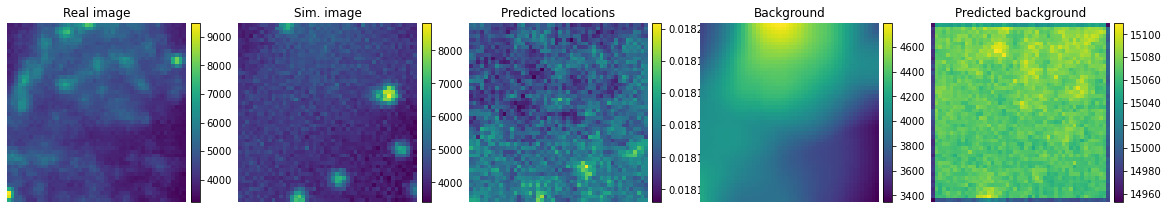

In [ ]:
_ = sl_plot(x, xsim_noise, None, None, background, outp)

(array([  23379.,  140382.,  588099.,  715988., 1903022., 3296645.,
        2786806., 1454096., 1186050.,   98301.]),
 array([-4.0528736, -4.043825 , -4.0347767, -4.025728 , -4.01668  ,
        -4.0076313, -3.998583 , -3.9895346, -3.9804862, -3.9714377,
        -3.9623892], dtype=float32),
 <BarContainer object of 10 artists>)

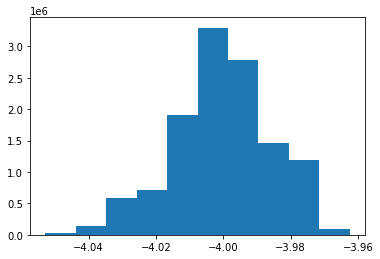

In [ ]:
plt.hist(cpu(outp['logits'].reshape(-1)))

In [ ]:
_ = wandb.init(project=cfg.output.project, 
               config=OmegaConf.to_container(cfg, resolve=True),
               dir=cfg.output.log_dir,
               group=cfg.output.group,
               name=cfg.run_name,
               mode='disabled'
          )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0 368


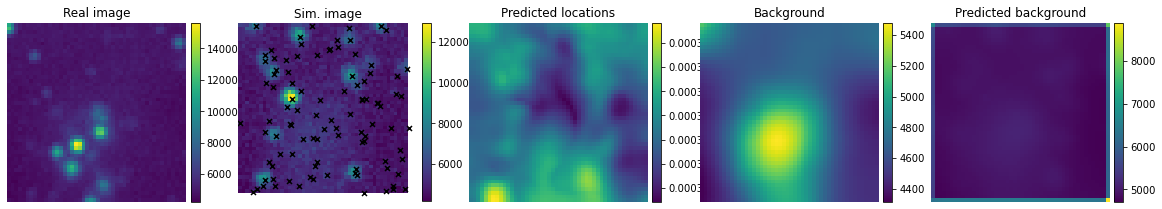

0 1031


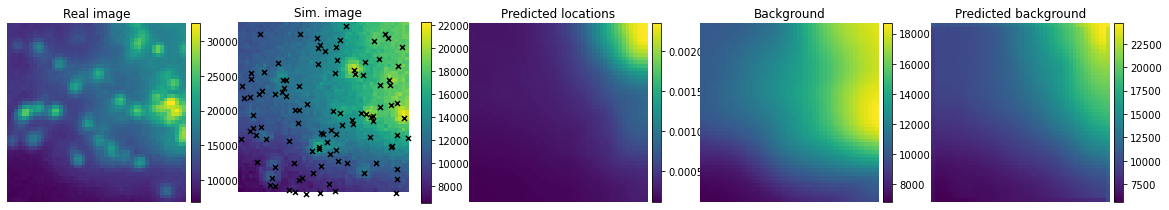

0 670


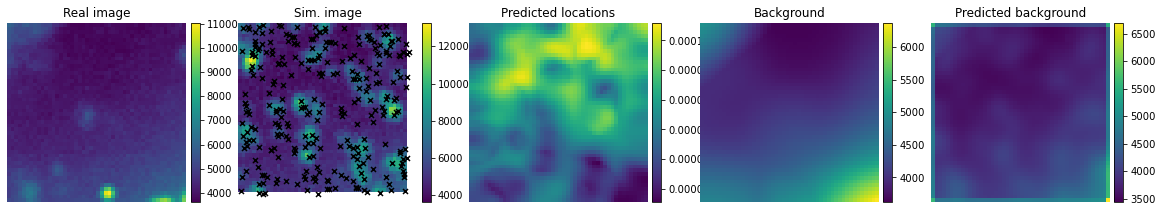

0 1011


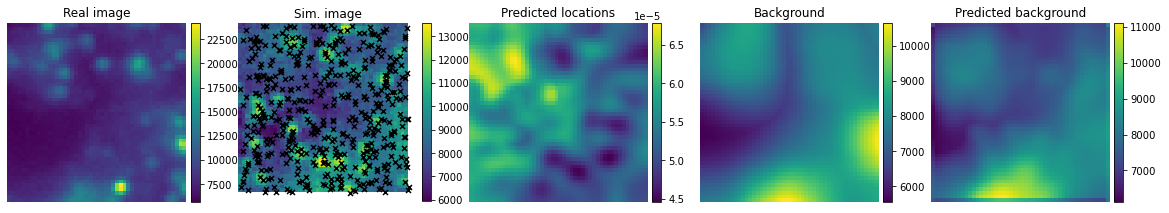

0 553


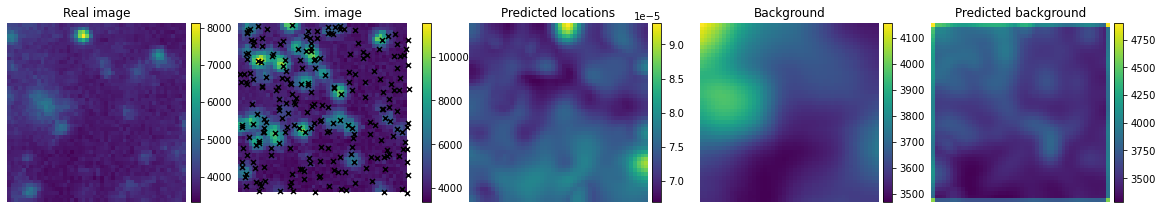

0 502


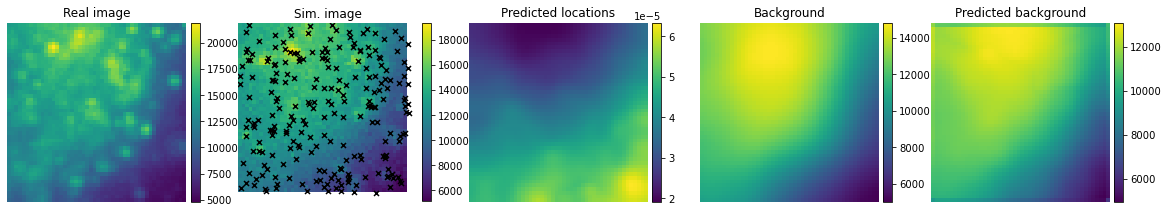

0 850


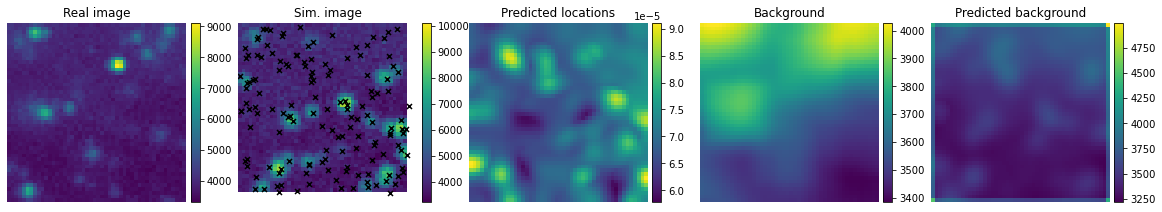

0 682


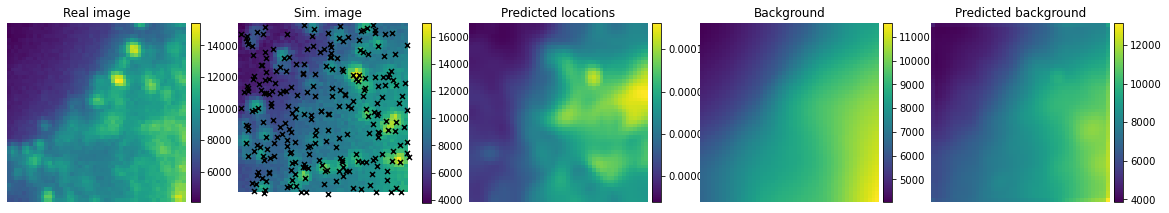

0 947


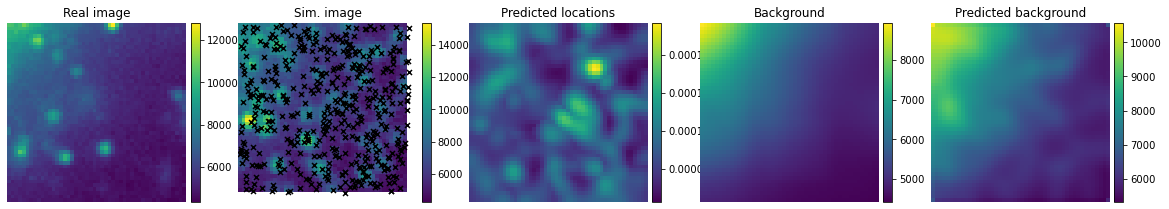

0 512


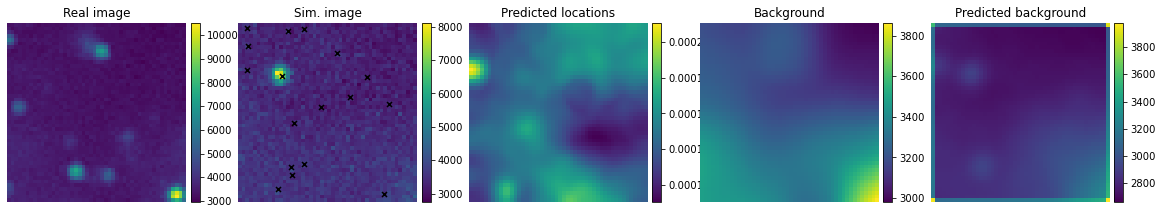

0 758


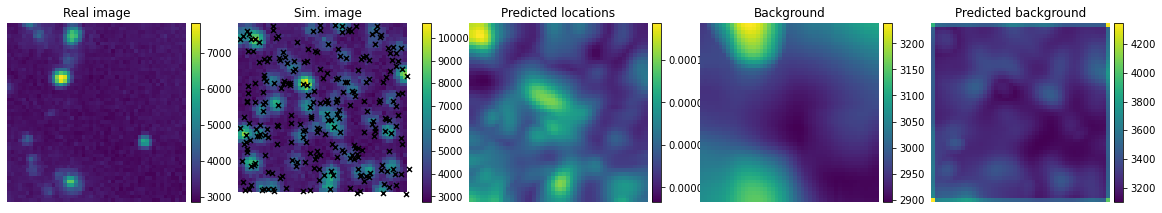

0 69


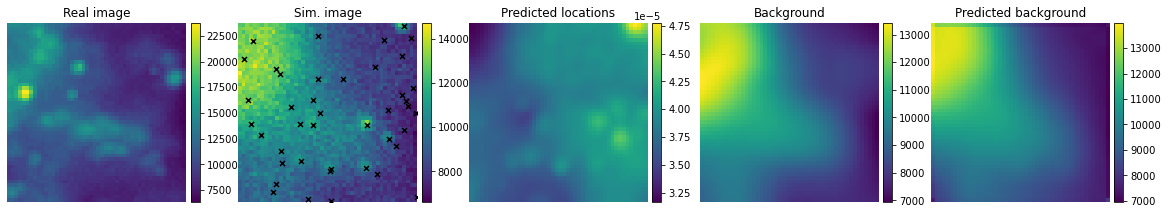

0 573


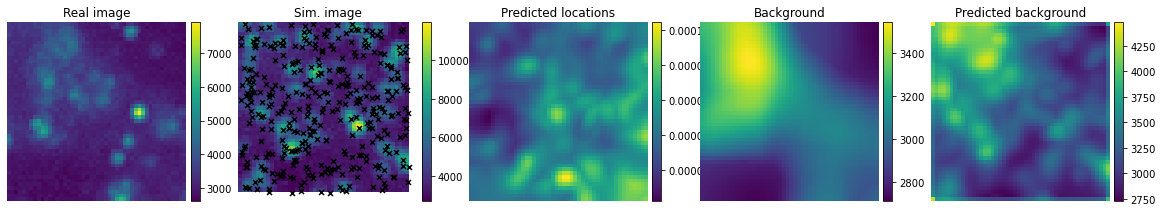

0 847


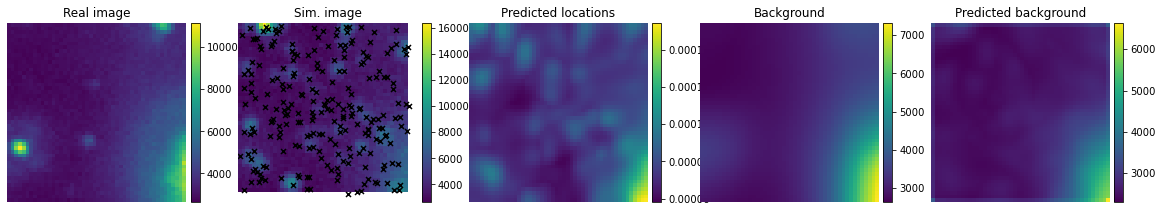

0 762


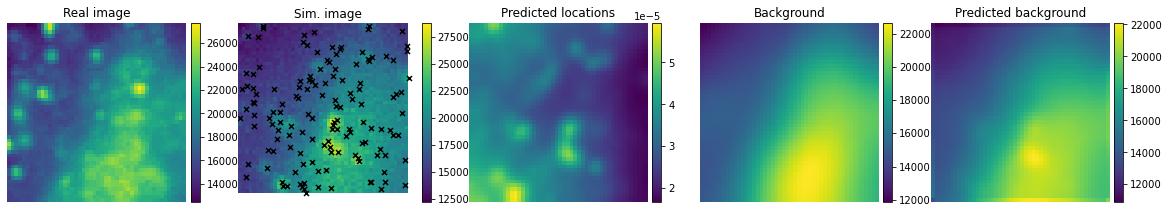

0 755


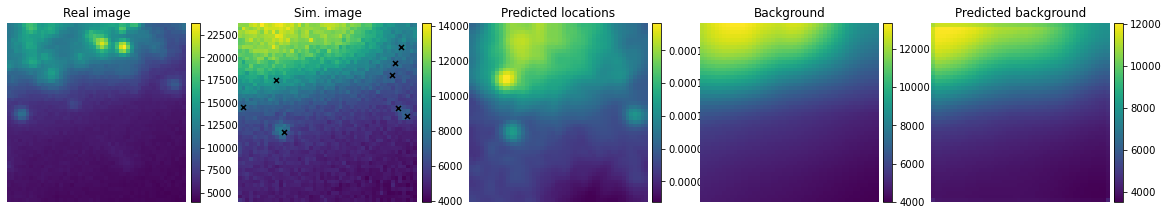

0 626


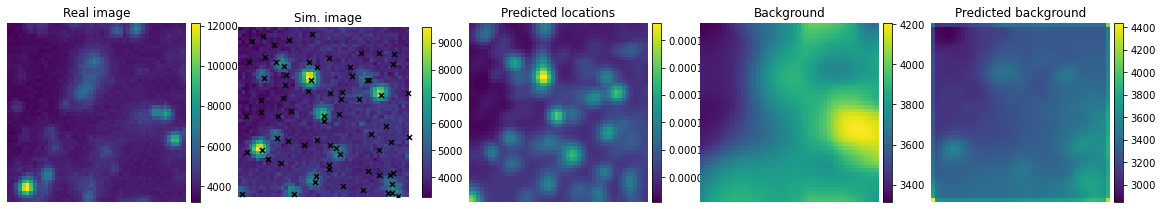

0 1003


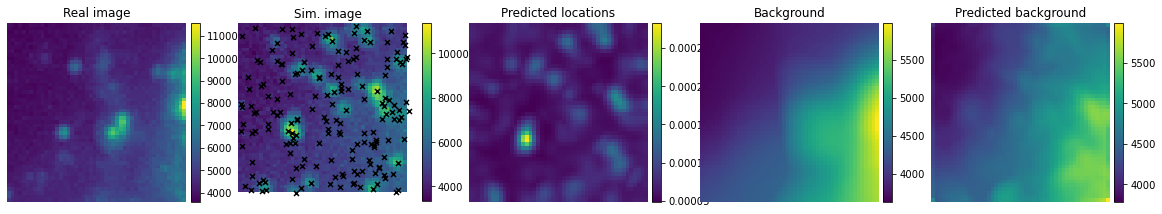

0 765


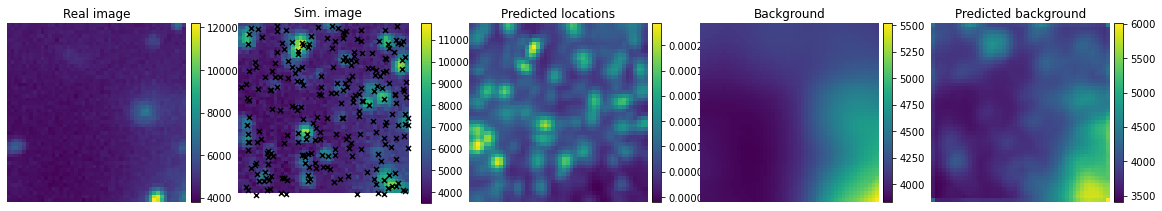

0 665


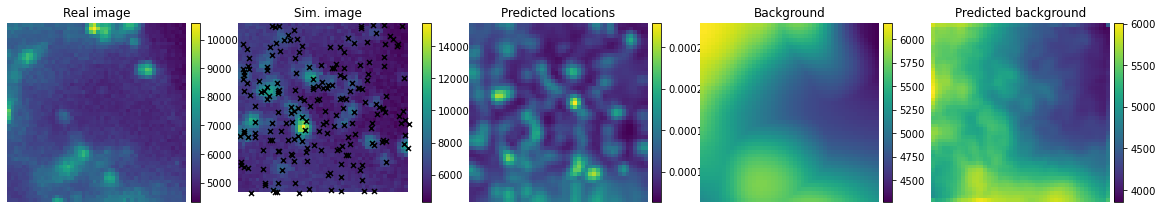

0 641


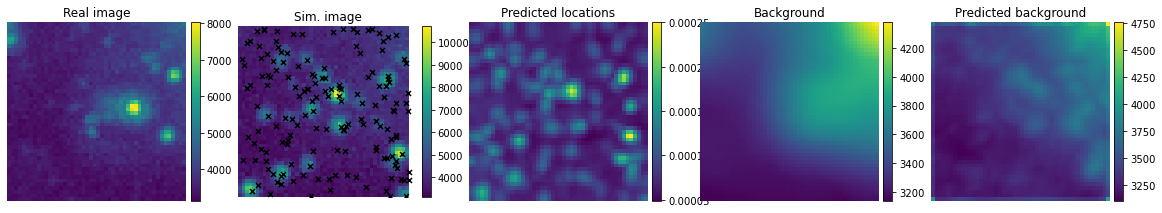

0 990


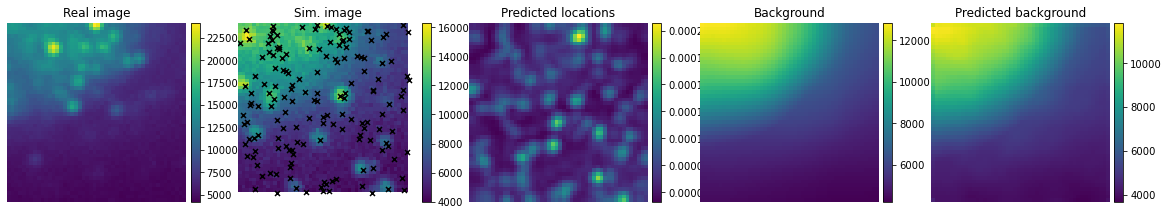

0 975


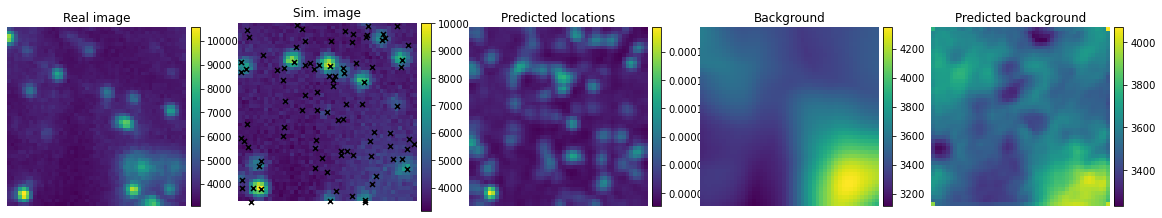

KeyboardInterrupt: 

In [ ]:
train(cfg=cfg,
     model=model, 
     microscope=micro, 
     post_proc=post_proc,
     dl=decode_dl, 
     optim_dict=optim_dict, 
     eval_dict=eval_dict)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.


In [ ]:
outp.shape